In [1]:
import os 
os.environ['LD_LIBRARY_PATH'] = ':'.join([os.environ.get('LD_LIBRARY_PATH', ''), '/usr/local/cuda-9.0/lib64/'])
os.environ['PATH'] = ':'.join([os.environ.get('PATH', ''), '/usr/local/cuda-9.0/lib64/'])

In [2]:
### Importing the basic modules

#### First part: Analysis and data pre-processing
import os           # Working directory
import pandas as pd # Data processing
import matplotlib
import matplotlib.pyplot as plt # Common graphing interface (check also plotly and plotnine)

#### Second part: models and Hyperparameter optimization
import tensorflow as tf
import keras 
import numpy as np
from functools import partial

from keras.activations import relu, softmax 
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.layers import Activation, BatchNormalization, Concatenate, concatenate, Dense, Dropout, Input, InputLayer, Lambda, LeakyReLU
#from keras.layers.merge import _Merge
from keras.losses import mse, binary_crossentropy, categorical_crossentropy, mean_squared_error
import keras.metrics as metrics
from keras.models import Model, Sequential
from keras.utils import plot_model
from keras import backend as K
from keras import metrics

#### Third part: model validation and graphs
import geopandas as gpd

# Bayesian optimization modules
#import GPy, GPyOpt

#### Extra
import random as rn

# Personal modules
from Utils import tuUtils
from Utils import validationUtils
from Utils import plotUtils
from Utils import validationGAN
from GAN.wganModel import WGAN

2023-12-23 01:39:27.981364: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-23 01:39:27.981426: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-23 01:39:27.982556: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-23 01:39:28.178330: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# prevent tensorflow from allocating the entire GPU memory at once
#from keras.backend.tensorflow_backend import set_session
#from keras.backend import set_session
config = tf.compat.v1.ConfigProto()
#"""
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "0"
#session = tf.Session(config=config)
#"""
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

2023-12-23 01:39:33.187201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-23 01:39:33.223374: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-23 01:39:33.223891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
os.chdir('/home/s212945/snap/snapd-desktop-integration/current/Documents/Thesis/MSc_PopSyn/Sigga_Luis/Data')

In [5]:
df_dtypes = {
    'CarModelYear': 'category',
    'Education': 'category',
    'FamNumAdults': 'int64',
    'FamNumPers': 'int64',
    'FuelType': 'category',
    'Gender': 'category',
    'Handicap': 'category',
    'HomeAdrZone': 'category',
    'HousehCarOwnership': 'category',
    'HousehNumAdults': 'int64',
    'HousehNumPers': 'int64',
    'HousehNumcars': 'int64',
    'HwDayspW': 'category',
    'IncFamily2000': 'int64',
    'IncRespondent2000': 'int64',
    'KidsBetween0and4': 'int64',
    'KidsBetween4and15': 'int64',
    'MunicipalityDest': 'category',
    'MunicipalityOrigin': 'category',
    'PopSocio': 'category',
    'PrimOccZone': 'category',
    'RespAgeCorrect': 'int64',
    'RespHasBicycle': 'category',
    'RespHasRejsekort': 'category',
    'RespIsmemCarshare': 'category',
    'RespPrimOcc': 'category',
    'ResphasDrivlic': 'category',
    'Sector': 'category',
    'WorkHourType': 'category',
    'WorkHoursPw': 'float64',
    'Year': 'category',
    'HomeParkPoss': 'category',
    'HousehAccomodation': 'category',
    'HousehAccOwnorRent': 'category',
    'PosInFamily': 'category',
    'PrimModeDay': 'category',
    'ModeChainTypeDay': 'category',
    'RespHasSeasonticket': 'category'
}

train = pd.read_csv('train_newCat.csv', sep=',', dtype=df_dtypes)
test = pd.read_csv('test_newCat.csv', sep=',', dtype=df_dtypes)

train.drop(train.columns[train.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)
test.drop(test.columns[test.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)

samp_df = train


In [6]:
#samp_df.drop(['SessionId', 'RespAgeCorrect'], axis=1, inplace=True)

# Definition of global lists for numerical and categorical variables. These will be used for pre processing and estimation
# Numerical and Categorical variable definitions 
numerical = ['IncFamily2000', 'IncRespondent2000', 'WorkHoursPw', 
             'FamNumAdults', 'FamNumPers', 'HousehNumAdults', 'HousehNumcars', 
             'HousehNumPers', 'RespAgeCorrect']

numerical_col_n = len(numerical) # Number of numerical variable

categorical = [col for col in list(samp_df) if col not in numerical]
samp_df[categorical] = samp_df[categorical].astype('category')

samp_df = samp_df[numerical + categorical]

categorical = [col for col in list(samp_df) if col not in numerical]
samp_df[categorical] = samp_df[categorical].astype('category')
categorical_col_n = len(categorical) # Number of categorical variables
categories_n = [] # Number of categories in each categorical variable
for cat in categorical:
    categories_n.append(len(samp_df[cat].cat.categories)) 
categories_cum = list(np.cumsum(categories_n)) # Cumulative sum of number of categorical variables
categories_cum = [x for x in categories_cum] # We take one out because they will be indexes
categories_cum = [0] + categories_cum

# Sort the dataset columns
samp_df = samp_df.reindex(numerical+categorical, axis=1)

#BINNING=False
#train, test, validation, pre_one_hot_df, one_hot_df, col_names, scaler = tuUtils.data_creator(samp_df, numerical=numerical, train_prop=0.812, val_prop=0.25, binning=BINNING, condition_on=None) # , quantiles=5 if dim too big

#n_inputs = train.shape[1]

train, pre_one_hot_df, one_hot_df, col_names, scaler = tuUtils.data_creator_noSplitting(samp_df, numerical)

n_inputs = train.shape[1]


train = np.array(train)


Index(['IncFamily2000', 'IncRespondent2000', 'WorkHoursPw', 'FamNumAdults',
       'FamNumPers', 'HousehNumAdults', 'HousehNumcars', 'HousehNumPers',
       'RespAgeCorrect', 'HousehCarOwnership_0.0',
       ...
       'ModeChainTypeDay_120.0', 'ModeChainTypeDay_130.0',
       'ModeChainTypeDay_132.0', 'ModeChainTypeDay_133.0',
       'ModeChainTypeDay_19.0', 'ModeChainTypeDay_2.0',
       'ModeChainTypeDay_21.0', 'ModeChainTypeDay_29.0',
       'ModeChainTypeDay_50.0', 'ModeChainTypeDay_90.0'],
      dtype='object', length=13243)
Train shape is: (97895, 13243)


/tmp/ipykernel_3581741/235132026.py:39: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  train = np.array(train)


In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [8]:
epochs_WGAN = 10000
wgan_latent_dim = 150
_WGAN = WGAN(train=train, validation=test, numerical_col_n=numerical_col_n,
             categorical_col_n = categorical_col_n, categories_n = categories_n, 
             categories_cum = categories_cum, # Data
             eval_set=['MunicipalityOrigin', 'ResphasDrivlic', 'PopSocio'], 
             col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df,# Data
             intermediate_dim_gen=1024, latent_dim=wgan_latent_dim, n_hidden_layers_gen=5, # Generator architecture 
             intermediate_dim_crit=1024, n_hidden_layers_crit=1, # Critic architecture 
             batch_size=512, epochs=epochs_WGAN, gen_learn_rate=3.29010632e-04 ,
             crit_learn_rate=3.29010632e-04 , clip_value=0.01, nCritic=5)#, drop_rate_g=0., drop_rate_c=0.10) # drop_rate_g=0., drop_rate_c=0.25
_WGAN.wgan_evaluate()

2023-12-23 01:40:01.750093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-23 01:40:01.750503: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-23 01:40:01.750822: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

16/16 [==============================] - 1s 5ms/step


2023-12-23 01:40:04.574093: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55fc30119f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-23 01:40:04.574268: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-12-23 01:40:04.574299: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-12-23 01:40:04.590602: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-23 01:40:04.639439: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-23 01:40:04.986011: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 [==============================] - 0s 13ms/step
0 [D loss: -0.231319, acc.: 0.00%] [G loss: 0.320592]
16/16 [==============================] - 0s 9ms/step
100 [D loss: -0.020107, acc.: 0.00%] [G loss: -0.004530]
16/16 [==============================] - 0s 11ms/step
200 [D loss: -0.025909, acc.: 0.00%] [G loss: -0.002163]
16/16 [==============================] - 0s 10ms/step
300 [D loss: -0.020857, acc.: 0.00%] [G loss: -0.001929]
16/16 [==============================] - 0s 7ms/step
400 [D loss: -0.021779, acc.: 0.00%] [G loss: -0.002008]
16/16 [==============================] - 0s 16ms/step
500 [D loss: -0.019829, acc.: 0.00%] [G loss: -0.001962]
16/16 [==============================] - 0s 7ms/step
600 [D loss: -0.020914, acc.: 0.00%] [G loss: -0.002441]
16/16 [==============================] - 0s 12ms/step
700 [D loss: -0.021308, acc.: 0.00%] [G loss: -0.001756]
16/16 [==============================] - 0s 11ms/step
800 [D loss: -0.020722, acc.: 0.00%] [G loss: -0.001647]
16/16 [

2023-12-23 15:40:42.562696: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2210203728 exceeds 10% of free system memory.


Evaluating with MAE
Using variables ['MunicipalityOrigin', 'ResphasDrivlic', 'PopSocio']
MAE:0.0005317997121275809, MSE:1.4896097735119008e-06, RMSE:0.001220495708108759, SRMSE:1.3962470900764203


0.0005317997121275809

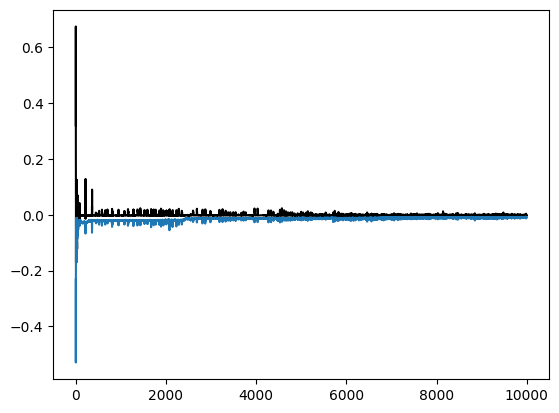

In [9]:
plt.plot(range(epochs_WGAN), _WGAN.gen_loss, 'k', range(epochs_WGAN), _WGAN.crit_loss);

In [10]:
_WGAN.n_samples = len(test)
wgan_n  = tuUtils.samples_to_df(_WGAN.sampler(), print_duplicates=False, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df, numerical=numerical, scaler=scaler, binning=False)
wgan_n.head()

1304/1304 [==============================] - 6s 5ms/step


2023-12-23 15:41:10.694008: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2210203728 exceeds 10% of free system memory.


,HousehCarOwnership,Year,Gender,Education,Handicap,PopSocio,RespPrimOcc,KidsBetween0and15,KidsBetween0and4,CarModelYear,MunicipalityOrigin,MunicipalityDest,HomeAdrZone,PrimOccZone,WorkHourType,RespHasBicycle,ResphasDrivlic,RespHasRejsekort,RespIsmemCarshare,Sector,HwDayspW,FuelType,HomeParkPoss,RespHasSeasonticket,HousehAccomodation,HousehAccOwnorRent,PosInFamily,PrimModeDay,ModeChainTypeDay,IncFamily2000,IncRespondent2000,WorkHoursPw,FamNumAdults,FamNumPers,HousehNumAdults,HousehNumcars,HousehNumPers,RespAgeCorrect
0,1.0,2016,2,H40,2.0,1,210.0,0,0,2013.0,187,540.0,851761.0,751126.0,3.0,1.0,1.0,1.0,2.0,Education,5.0,1.0,4.0,2.0,1.0,1.0,12.0,11.0,2.0,407.386788,210.727562,167.922906,1.767267,2.155301,1.894354,2.312820,2.134425,26.411435
1,3.0,2011,1,H30,2.0,1,210.0,0,0,2001.0,766,820.0,787152.0,791231.0,2.0,2.0,1.0,6.0,2.0,Wood and paper products and printing,5.0,1.0,133.0,2.0,1.0,1.0,11.0,11.0,11.0,1000.232272,462.284974,19.708370,2.442364,2.936438,2.427486,3.128865,1.913062,40.957647
2,1.0,2009,2,H30,2.0,3,370.0,0,0,2006.0,810,MISSING,420054.0,MISSING,Not working,1.0,1.0,6.0,2.0,Activity not stated,0.0,1.0,232.0,2.0,4.0,1.0,12.0,11.0,21.0,271.816644,129.610800,0.055350,2.379414,2.322589,2.503314,1.690759,2.635808,59.165010
3,1.0,2012,2,H10,2.0,0,390.0,0,0,2000.0,390,MISSING,479254.0,MISSING,Not working,1.0,1.0,30.0,2.0,Activity not stated,0.0,2.0,112.0,1.0,4.0,1.0,12.0,31.0,21.0,114.967249,135.539117,-0.142964,2.679175,2.062631,3.082045,1.504356,2.457445,26.948491
4,1.0,2010,1,H10,2.0,3,360.0,0,0,2007.0,860,MISSING,630311.0,MISSING,Not working,1.0,1.0,5.0,2.0,Activity not stated,0.0,1.0,233.0,2.0,1.0,1.0,11.0,11.0,11.0,368.385056,288.574724,-0.170555,1.593801,1.267752,1.946248,1.345435,1.690552,51.205696


In [11]:
wgan_n.to_csv('WGAN_samples_v1_newCat.csv')

Aggregated variables: 
MunicipalityOrigin
Number of combinations: 98
corr = 0.908485
MAE = 0.003754
RMSE = 0.005671
SRMSE = 0.555726
r2 = 0.712066


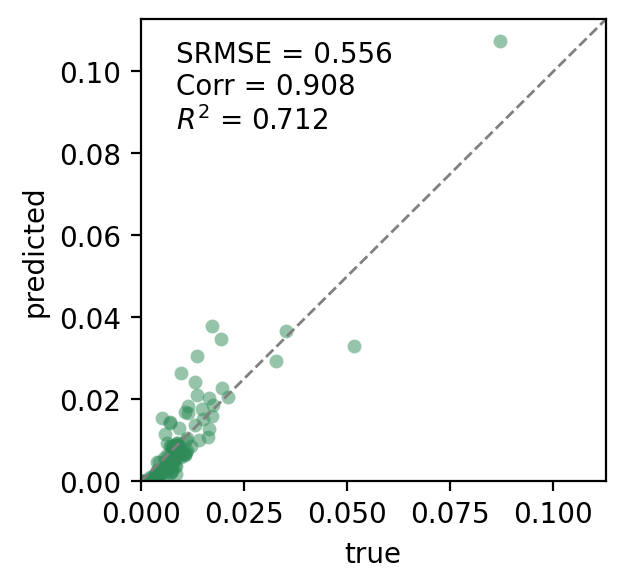

Aggregated variables: 
ResphasDrivlic
Number of combinations: 4
corr = 0.999686
MAE = 0.009647
RMSE = 0.009820
SRMSE = 0.039279
r2 = 0.998782


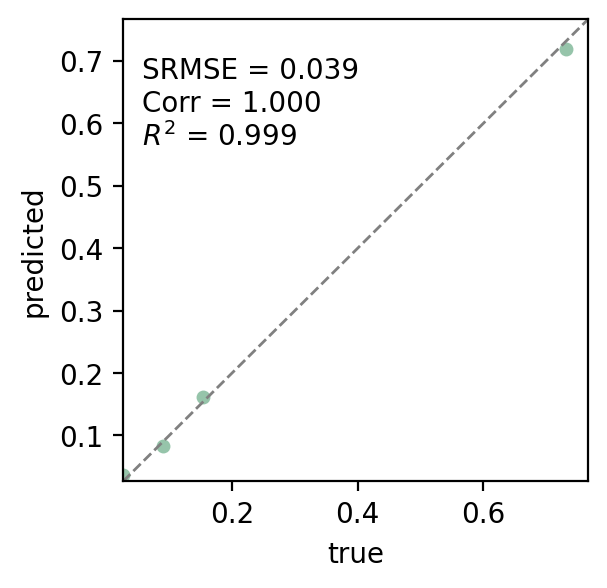

Aggregated variables: 
PopSocio
Number of combinations: 4
corr = 0.990153
MAE = 0.019030
RMSE = 0.022848
SRMSE = 0.091393
r2 = 0.977780


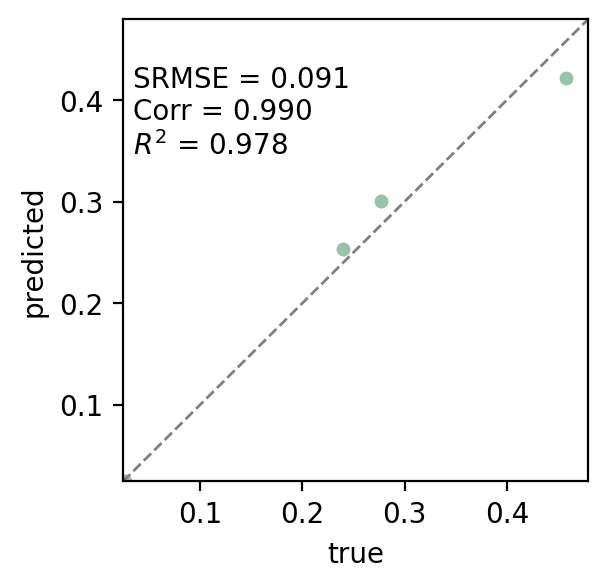

Aggregated variables: 
MunicipalityOrigin
ResphasDrivlic
Number of combinations: 392
corr = 0.897908
MAE = 0.001195
RMSE = 0.002385
SRMSE = 0.930286
r2 = 0.747801


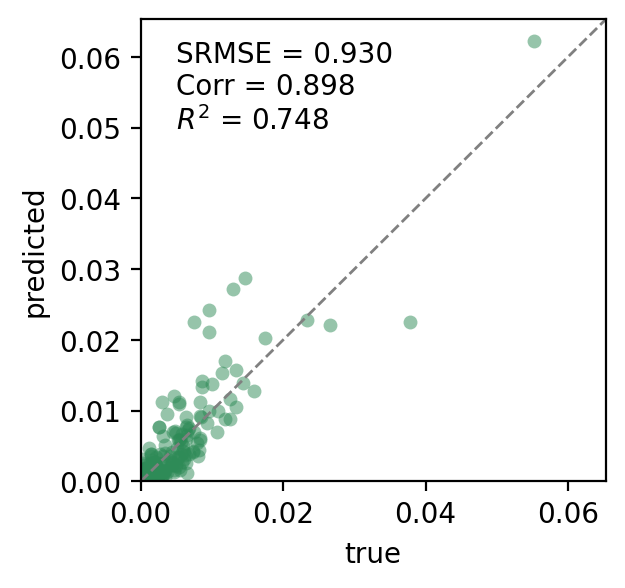

Aggregated variables: 
MunicipalityOrigin
ResphasDrivlic
PopSocio
Number of combinations: 1568
corr = 0.844890
MAE = 0.000537
RMSE = 0.001222
SRMSE = 1.396067
r2 = 0.589747


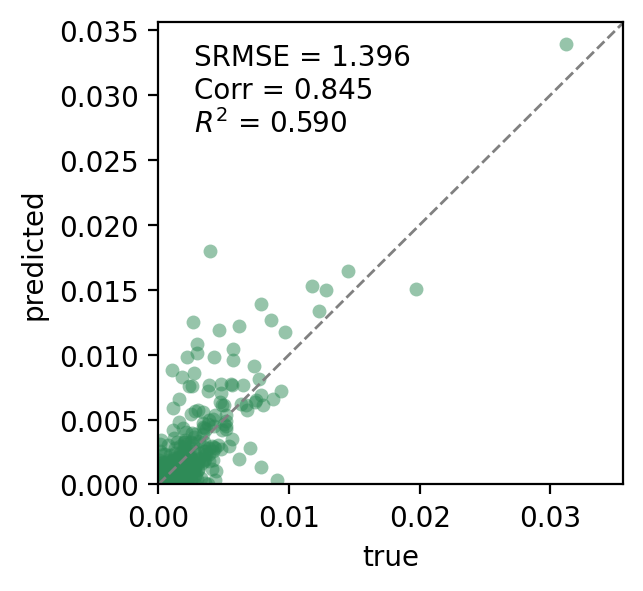

Aggregated variables: 
MunicipalityOrigin
ResphasDrivlic
PopSocio
Gender
Number of combinations: 3136
corr = 0.820501
MAE = 0.000316
RMSE = 0.000697
SRMSE = 1.446934
r2 = 0.510419


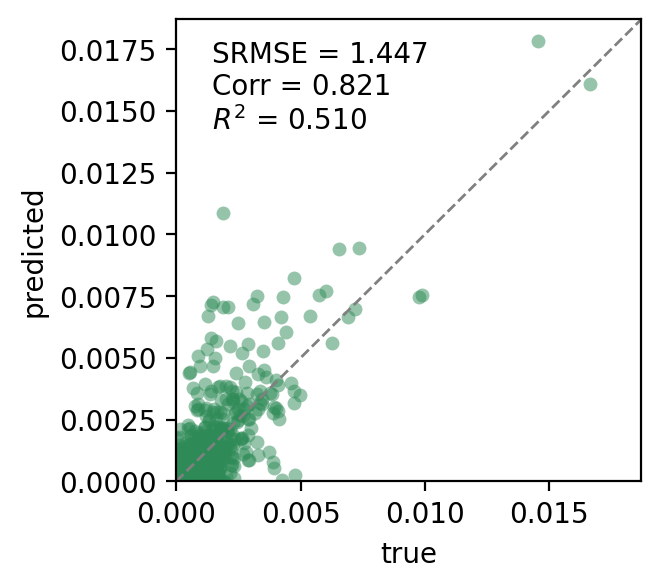

Aggregated variables: 
HomeAdrZone
Number of combinations: 6325
corr = 0.284171
MAE = 0.000261
RMSE = 0.001443
SRMSE = 9.125475
r2 = -95.258059


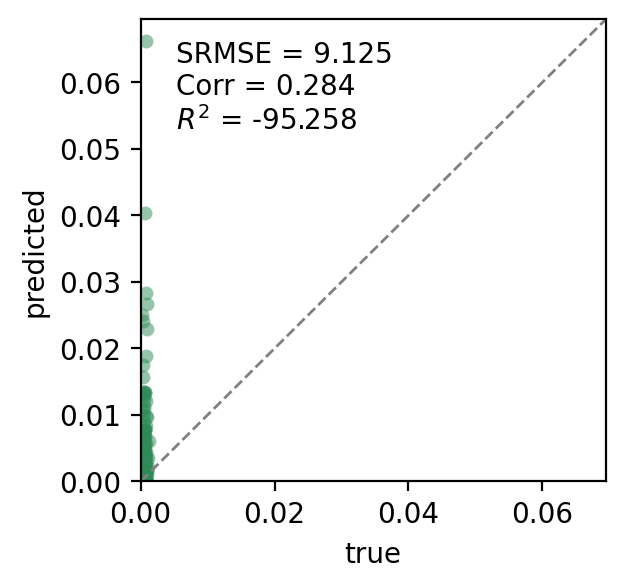

Aggregated variables: 
Education
Number of combinations: 8
corr = 0.997535
MAE = 0.010551
RMSE = 0.014010
SRMSE = 0.112077
r2 = 0.985118


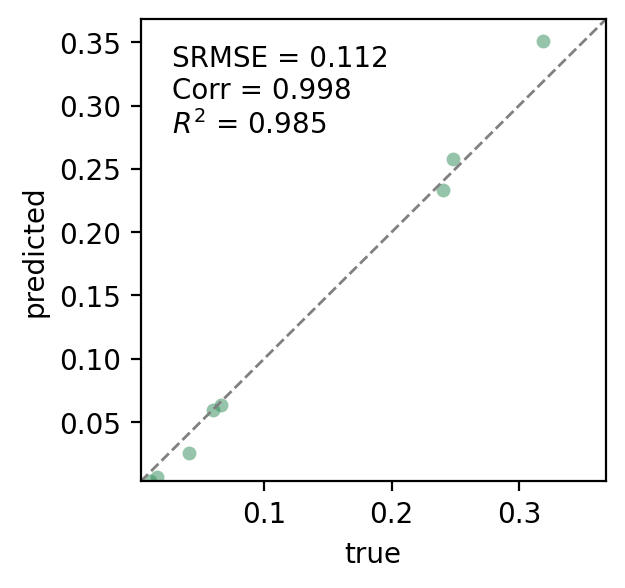

Aggregated variables: 
Sector
Number of combinations: 37
corr = 0.999254
MAE = 0.005255
RMSE = 0.011423
SRMSE = 0.422641
r2 = 0.966994


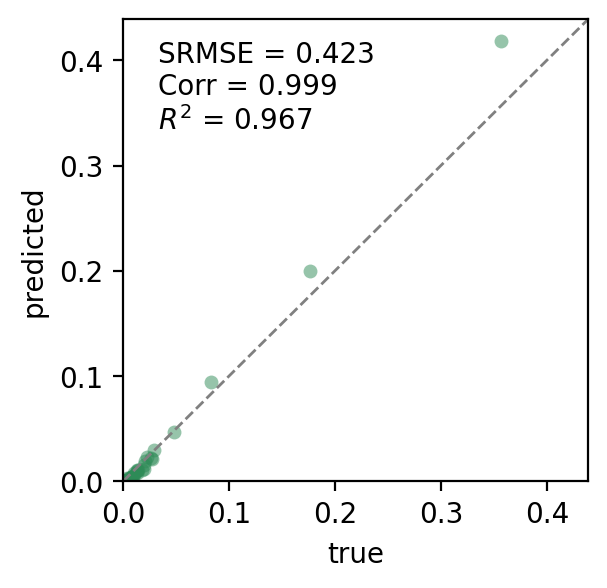

Aggregated variables: 
Education
Sector
Number of combinations: 296
corr = 0.990757
MAE = 0.001103
RMSE = 0.003312
SRMSE = 0.890815
r2 = 0.937243


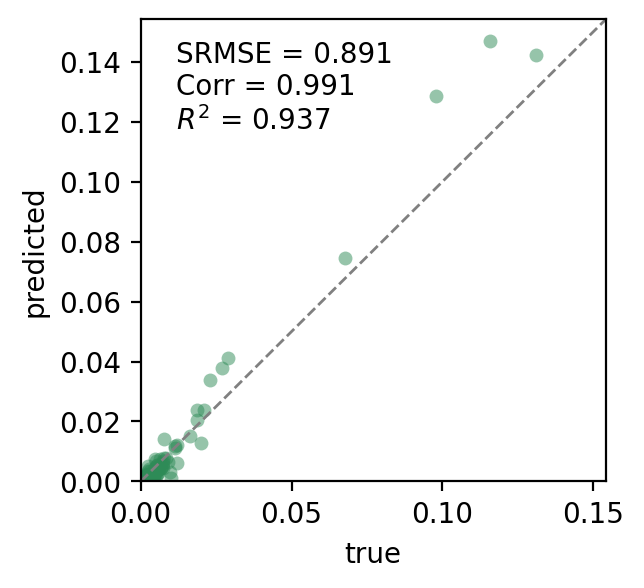

Aggregated variables: 
Education
Sector
Gender
Number of combinations: 592
corr = 0.982650
MAE = 0.000649
RMSE = 0.001914
SRMSE = 0.966356
r2 = 0.925050


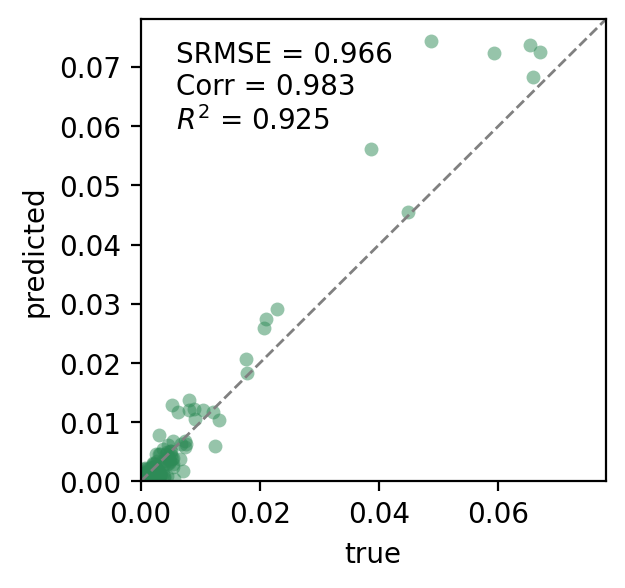

In [13]:
validationGAN.validate_Gan_Cat(wgan_n, test, test)

Variable: IncFamily2000
TtestResult(statistic=6.188191507775034, pvalue=6.114011330015032e-10, df=83446.0)


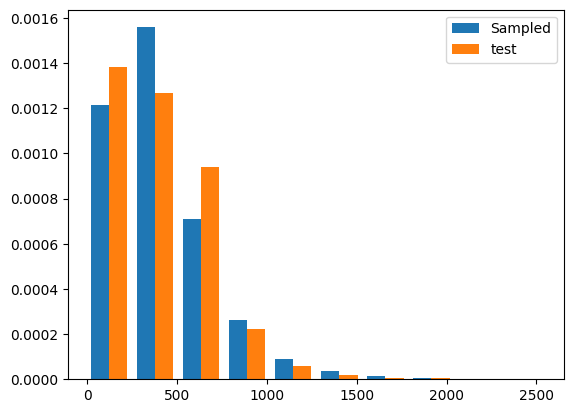

Variable: IncRespondent2000
TtestResult(statistic=-6.301493486459655, pvalue=2.962563386270142e-10, df=83446.0)


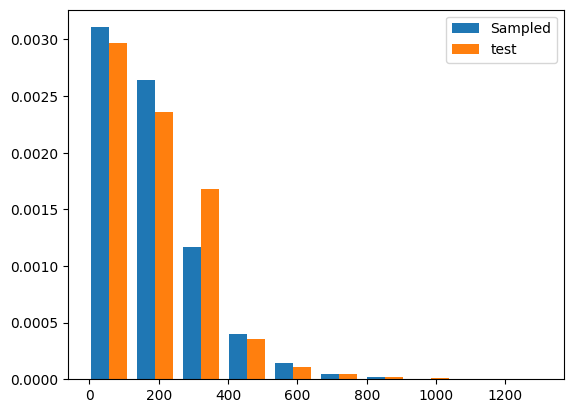

Variable: WorkHoursPw
TtestResult(statistic=1.0299048601324647, pvalue=0.3030576541247882, df=83446.0)


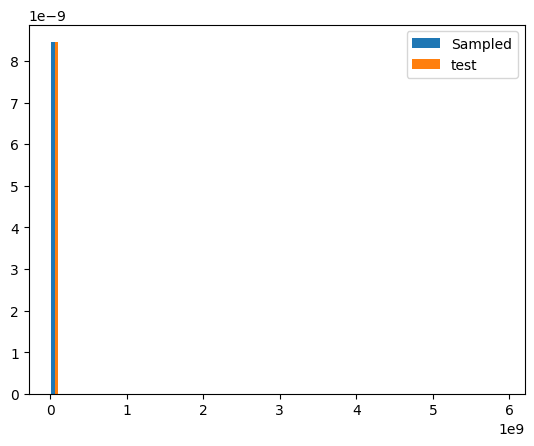

Variable: FamNumAdults
TtestResult(statistic=-32.030278206369196, pvalue=9.48904763306494e-224, df=83446.0)


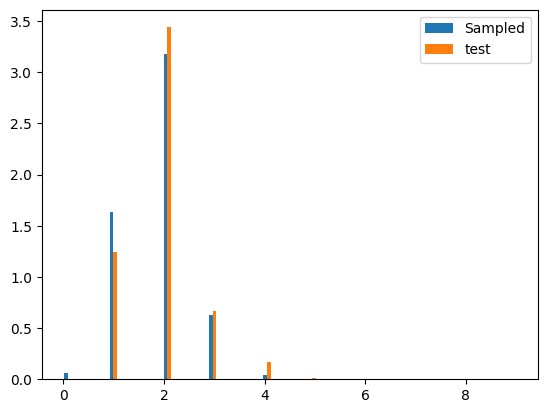

Variable: FamNumPers
TtestResult(statistic=12.98875302722928, pvalue=1.5446966222996298e-38, df=83446.0)


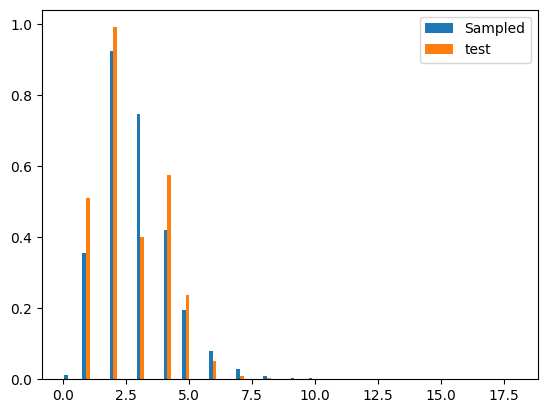

Variable: HousehNumAdults
TtestResult(statistic=-7.933312055849468, pvalue=2.1600423025323664e-15, df=83446.0)


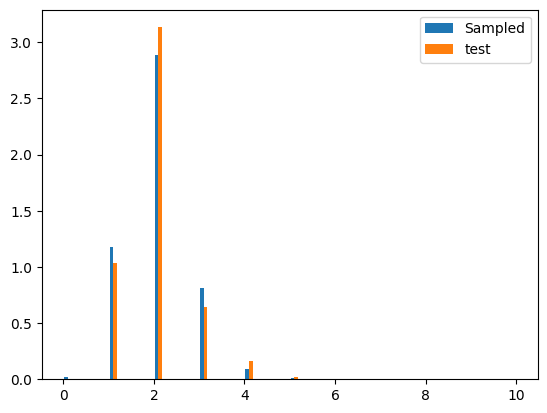

Variable: HousehNumcars
TtestResult(statistic=43.170192463881165, pvalue=0.0, df=83446.0)


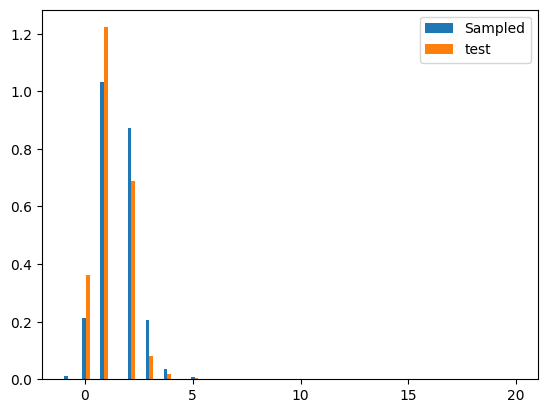

Variable: HousehNumPers
TtestResult(statistic=-25.258099836764043, pvalue=3.116186623338275e-140, df=83446.0)


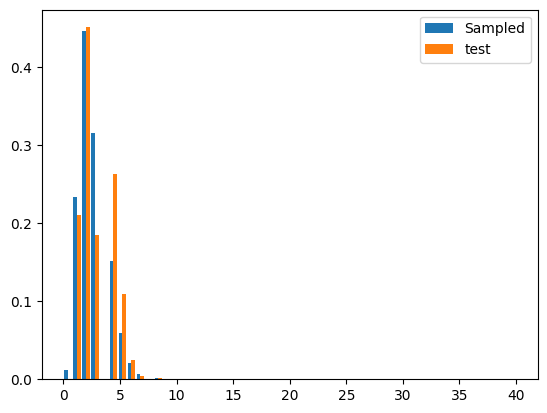

Variable: RespAgeCorrect
TtestResult(statistic=-34.69051027942481, pvalue=8.110977392869785e-262, df=83446.0)


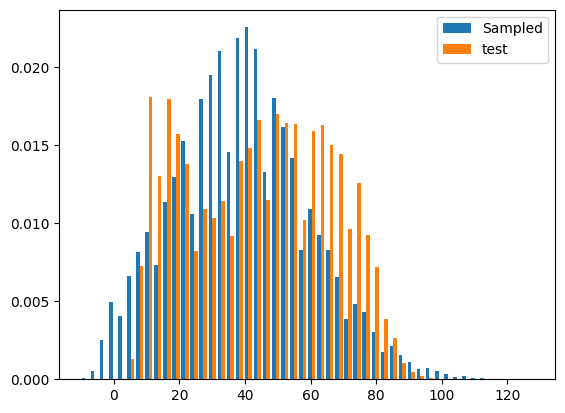

In [14]:
validationGAN.validate_Gan_num(test, round(wgan_n[numerical]))

In [15]:
from Utils import saveUtils
saveUtils.saveGenerator('generator_v1_newCat.h5', _WGAN)

/home/s212945/snap/snapd-desktop-integration/current/Documents/Thesis/.popsyn/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
samples = []
for i in range(100):
    _WGAN.n_samples = 30000
    wgan_n  = tuUtils.samples_to_df(_WGAN.sampler(), print_duplicates=False, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df)
    samples.append(wgan_n)
    
df = pd.concat(samples, ignore_index=True)
df.to_csv('wgan_samples.txt', sep=',', index=False)

938/938 [==============================] - 4s 4ms/step


In [17]:
samples = []
for i in range(100):
    _WGAN.n_samples = 30000
    wgan_n  = tuUtils.samples_to_df(_WGAN.sampler(), print_duplicates=False, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df)
    samples.append(wgan_n)
    
df = pd.concat(samples, ignore_index=True)
df.to_csv('wgan_samples_part2.txt', sep=',', index=False)

938/938 [==============================] - 3s 4ms/step
